In [123]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import typing as tp

##  1. Генерация данных и базовые оценки

In [81]:
N = 500
mu = 0
sigma = 5
np.random.seed(52)

dist = np.random.normal(mu, sigma, N)

In [82]:
aver_dist = np.mean(dist)
aver_theory = mu
print(f"Среднее: {aver_dist:.3f}, истинное: {aver_theory:.3f}, разница: {abs(aver_dist - aver_theory):.3f}")

median_dist = np.median(dist)
median_theory = mu
print(f"Медиана: {median_dist:.3f}, истинное: {median_theory:.3f}, разница: {abs(median_dist - median_theory):.3f}")

var_dist = np.var(dist, ddof=1)
var_theory = sigma ** 2
print(f"Дисперсия: {var_dist:.3f}, истинное: {var_theory:.3f}, разница: {abs(var_dist - var_theory):.3f}")

iqr_dist = np.percentile(dist, 75) - np.percentile(dist, 25)
iqr_theory = sts.norm.ppf(0.75, loc=mu, scale=sigma) - sts.norm.ppf(0.25, loc=mu, scale=sigma)
print(f"IQR: {iqr_dist:.3f}, истинное: {iqr_theory:.3f}, разница: {abs(iqr_dist - iqr_theory):.3f}")

Среднее: 0.363, истинное: 0.000, разница: 0.363
Медиана: 0.417, истинное: 0.000, разница: 0.417
Дисперсия: 22.187, истинное: 25.000, разница: 2.813
IQR: 6.567, истинное: 6.745, разница: 0.178


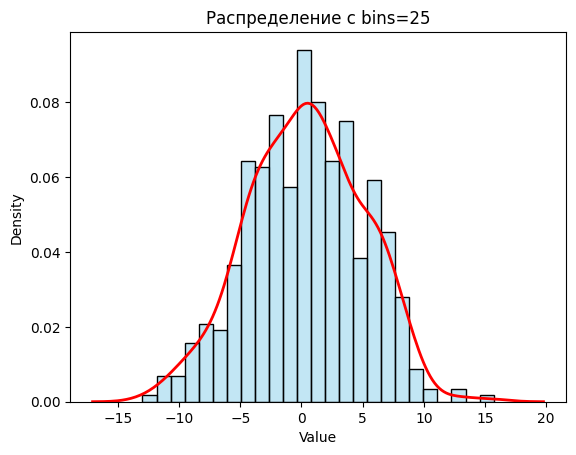

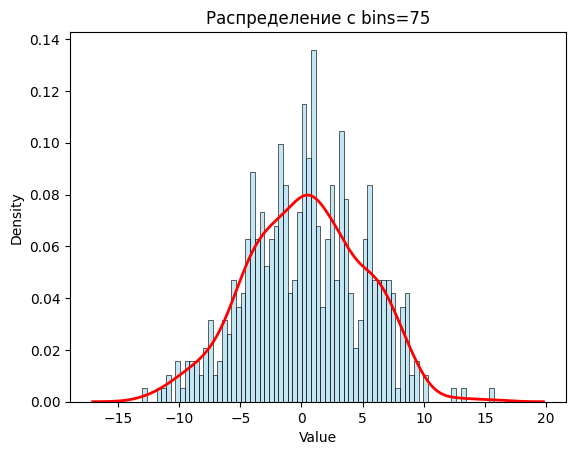

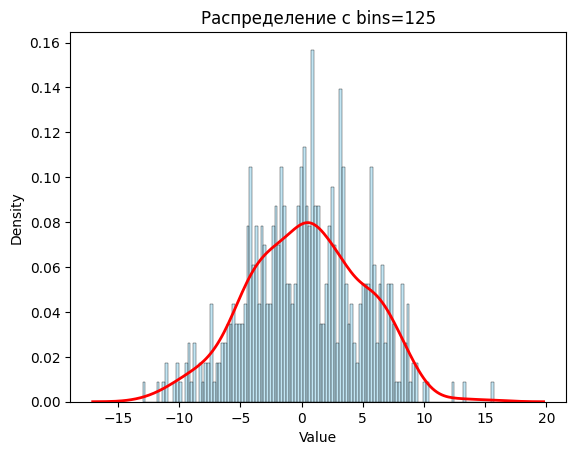

In [83]:
bin_vals = [25, 75, 125]
KDE_dist = sts.gaussian_kde(dist)
x_vals = np.linspace(dist.min(), dist.max(), N)
pdf_from_kde = KDE_dist(x_vals)

for bins in bin_vals:
    ax = sns.histplot(dist, bins=bins, stat='density', color='skyblue', alpha=0.5)
    sns.kdeplot(dist, ax=ax, color='red', lw=2)

    plt.title(f"Распределение с bins={bins}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()

##  2. Бутстрап для точечных оценок

In [84]:
n_bootstrap = 1000

btstrp_samples = np.array([np.random.choice(dist, size=len(dist), replace=True) for _ in range(n_bootstrap)])

btstrp_aver = np.array([np.mean(row) for row in btstrp_samples])
btstrp_median = np.array([np.median(row) for row in btstrp_samples])
btstrp_var = np.array([np.var(row) for row in btstrp_samples])
btstrp_iqr = np.array([np.percentile(row, 75) - np.percentile(row, 25) for row in btstrp_samples])

In [ ]:
def plot_bootstrap_statistic(data: np.array, dist_value: float, theory_value: float, name: str):
    """Построить гистограмму распределения метрики по подвыборкам

    Args:
        data (np.array): подвыборка
        dist_value (float): значение по всей выборке
        theory_value (float): истинное значение по генеральной выборке
        name (str): название метрики 

    Returns:
        _type_: пара figure-axis
    """

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(data, bins=75, color='skyblue', edgecolor='black', alpha=0.5)
    ax.axvline(dist_value, color='orange', lw=2, label=f'{name} по выборке')
    ax.axvline(theory_value, color='purple', lw=1, label=f'Теоретическое {name}')

    ax.set_xlabel(f"{name} по образцам")
    ax.set_ylabel("Частота")
    ax.set_title(f"Распределение метрики {name} по бутстрап-выборкам")

    ax.legend()

    return fig, ax

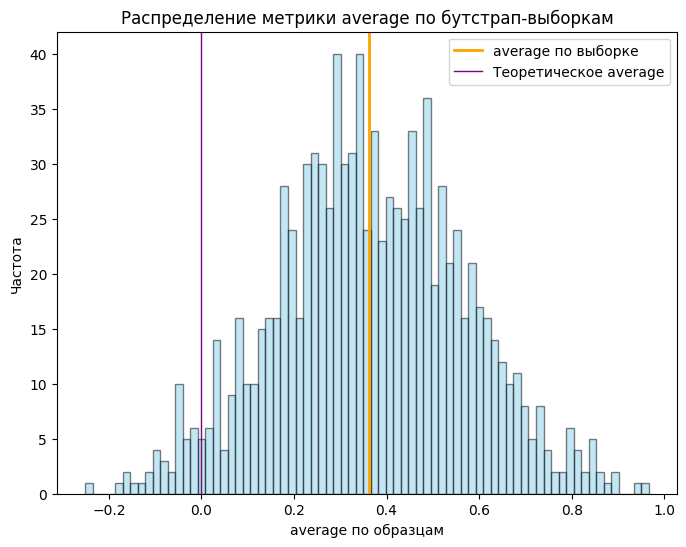

In [113]:
plot_bootstrap_statistic(btstrp_aver, aver_dist, aver_theory, 'average')
plt.show()

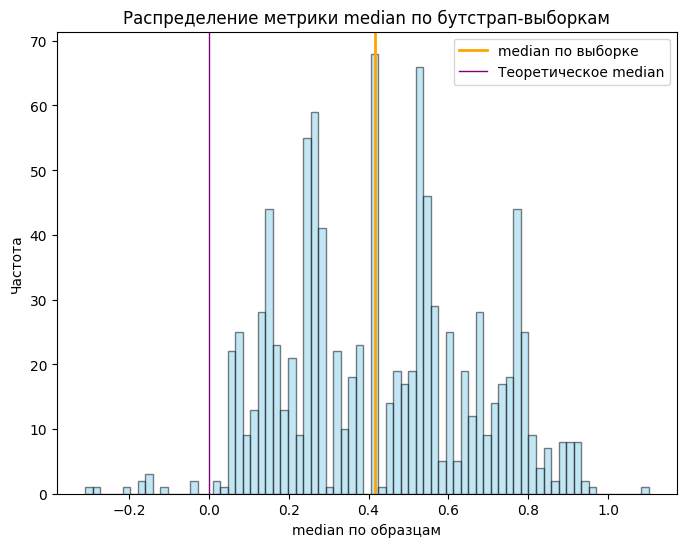

In [ ]:
plot_bootstrap_statistic(btstrp_median, median_dist, median_theory, 'median')
plt.show()

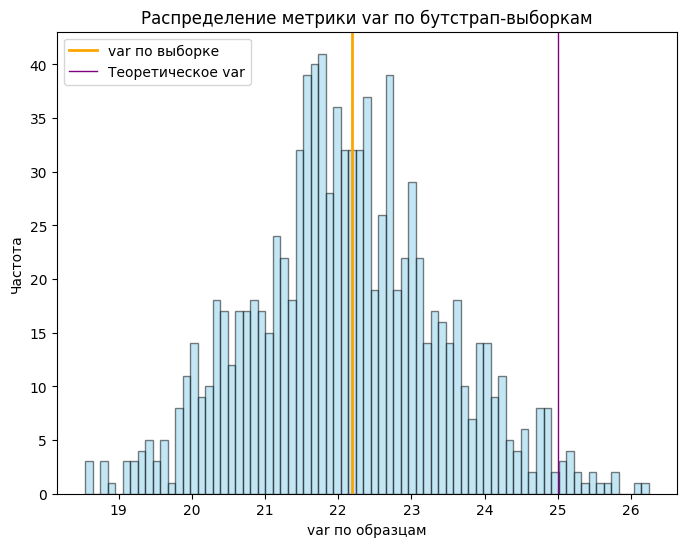

In [ ]:
plot_bootstrap_statistic(btstrp_var, var_dist, var_theory, 'var')
plt.show()

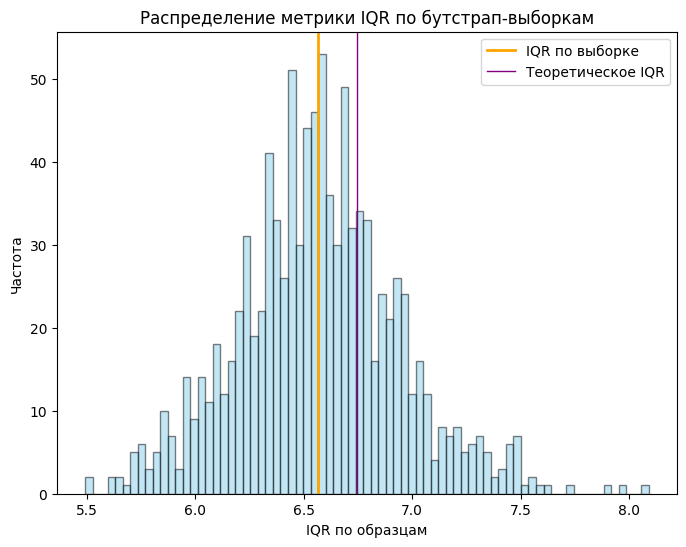

In [ ]:
plot_bootstrap_statistic(btstrp_iqr, iqr_dist, iqr_theory, 'IQR')
plt.show()

##  3. Построение доверительных интервалов

In [ ]:
def get_confidence_interval(data: np.array, alpha: float) -> np.array:
    """Найти границы доверительного интервала

    Args:
        data (np.array): массив данных 
        alpha (float): параметр уверенности

    Returns:
        np.array: пара начало-конец интервала
    """
    alpha = min(100, abs(100 * alpha))
    return np.percentile(data, [alpha/2, 100 - alpha/2])

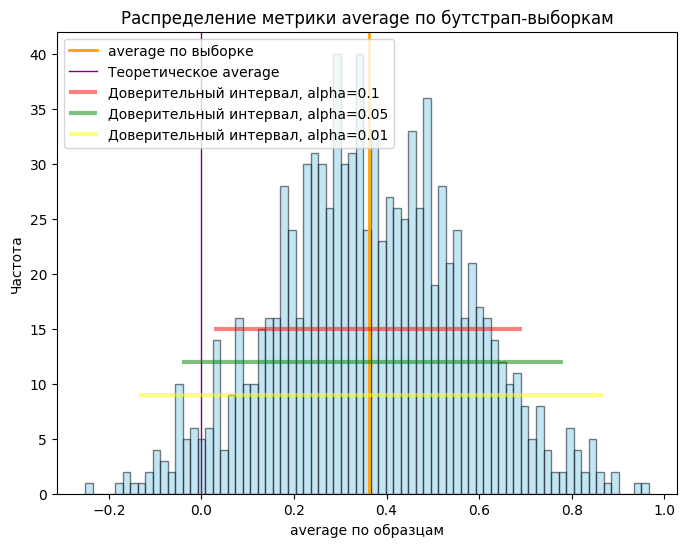

In [121]:
alphas = [0.1, 0.05, 0.01]
colors = ['red', 'green', 'yellow', 'blue', 'black']

fig, ax = plot_bootstrap_statistic(btstrp_aver, aver_dist, aver_theory, 'average')
for i, a in enumerate(alphas):
    interval = get_confidence_interval(btstrp_aver, a)
    ax.hlines(max(0, 15 - 3 * i), interval[0], interval[1], linestyles='solid', label=f'Доверительный интервал, alpha={a}', linewidth=3, colors=colors[i], alpha=0.5)
ax.legend()

plt.show()

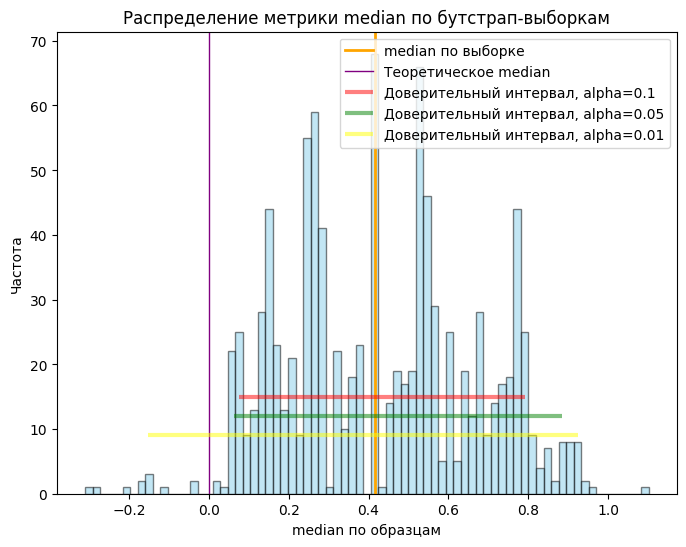

In [122]:
fig, ax = plot_bootstrap_statistic(btstrp_median, median_dist, median_theory, 'median')
for i, a in enumerate(alphas):
    interval = get_confidence_interval(btstrp_median, a)
    ax.hlines(max(0, 15 - 3 * i), interval[0], interval[1], linestyles='solid', label=f'Доверительный интервал, alpha={a}', linewidth=3, colors=colors[i], alpha=0.5)
ax.legend()

plt.show()

##  4. Влияние объема выборки и числа итераций

In [ ]:
def get_average_confidence_interval_ext(n: int, b: int, alpha: float) -> np.array:
    """По заданному размеру выборки и итераций бутстрапа найти границы доверительного интервала

    Args:
        n (int): размер выборки
        b (int): кол-во итераций в бутстрапе
        alpha (float): параметр уверемнности

    Returns:
        np.array: границы интервала
    """
    data = np.random.normal(mu, sigma, n)

    samples = np.array([np.random.choice(data, size=len(data), replace=True) for _ in range(b)])
    aver_samples = np.array([np.mean(row) for row in samples])

    return get_confidence_interval(aver_samples, alpha)

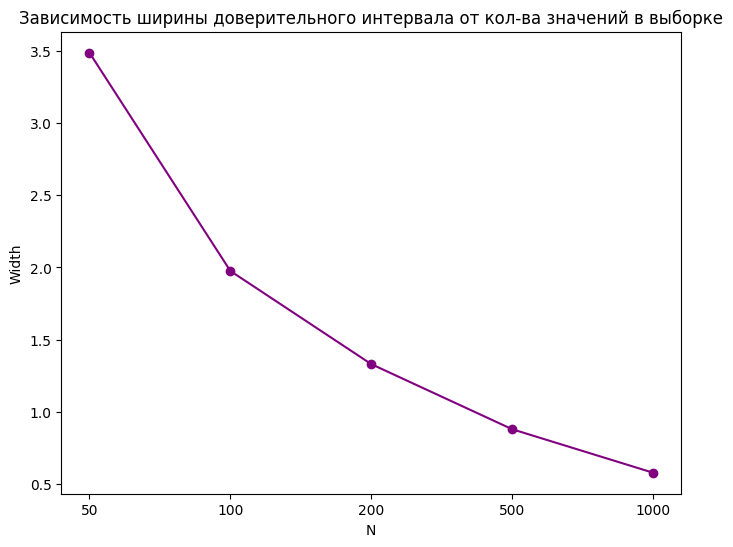

In [92]:
Ns = [50, 100, 200, 500, 1000]
widths = []

for n in Ns:
    interval = get_average_confidence_interval_ext(n, 1000, 0.05)
    widths.append(interval[1] - interval[0])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.arange(len(widths)), widths, color='purple', marker='o')

ax.set_title('Зависимость ширины доверительного интервала от кол-ва значений в выборке')
ax.set_xticks(np.arange(len(Ns)))
ax.set_xticklabels(Ns)
ax.set_xlabel("N")
ax.set_ylabel("Width")

plt.show()

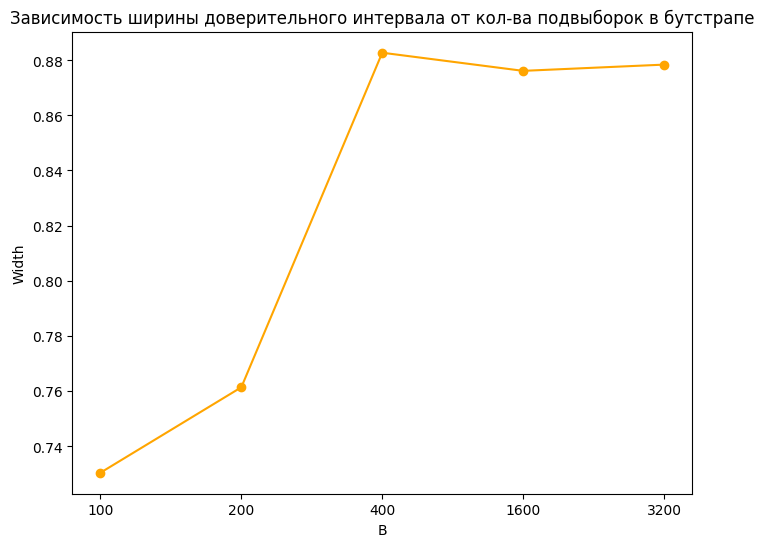

In [125]:
Bs = [100, 200, 400, 1600, 3200]

widths = []

for b in Bs:
    interval = get_average_confidence_interval_ext(500, b, 0.05)
    widths.append(interval[1] - interval[0])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.arange(len(widths)), widths, color='orange', marker='o')

ax.set_title('Зависимость ширины доверительного интервала от кол-ва подвыборок в бутстрапе')
ax.set_xticks(np.arange(len(Bs)))
ax.set_xticklabels(Bs)
ax.set_xlabel("B")
ax.set_ylabel("Width")

plt.show()

##  5. Проверка покрытия интервалов

In [105]:
Ns = [50, 100, 200, 500, 1000]
Bs = [100, 200, 400, 1600, 3200]

df = []

for n in Ns:
    for b in Bs:
        c = 0
        for _ in range(100):
            data = np.random.normal(0, 1, n)
            samples = np.array([np.random.choice(data, size=len(data), replace=True) for _ in range(b)])
            aver_samples = np.array([np.mean(row) for row in samples])
            interval = get_confidence_interval(aver_samples, 0.05)

            if interval[1] >= 0 >= interval[0]: c += 1
        
        df.append({'N': n, 'B': b, 'Доля покрытия': c/100})

df = pd.DataFrame(df)

df

,N,B,Доля покрытия
0,50,100,0.92
1,50,200,0.94
2,50,400,0.95
3,50,1600,0.98
4,50,3200,0.97
5,100,100,0.93
6,100,200,0.94
7,100,400,0.85
8,100,1600,0.95
9,100,3200,0.93


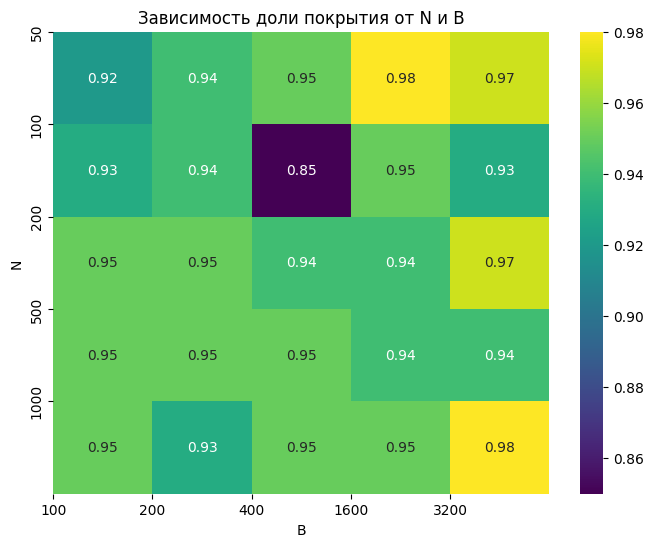

In [109]:
cover_matrix = np.zeros((len(Ns), len(Bs)))
bs = len(Bs)

for i in df.index:
    cover_matrix[i // bs, i % bs] = df.iloc[i]['Доля покрытия']

plt.figure(figsize=(8, 6))

ax = sns.heatmap(cover_matrix, annot=True, cmap='viridis')
ax.set_xticks(np.arange(len(Bs)))
ax.set_yticks(np.arange(len(Ns)))

ax.set_xticklabels(Bs)
ax.set_yticklabels(Ns)

ax.set_xlabel('B')
ax.set_ylabel('N')

ax.set_title("Зависимость доли покрытия от N и B")

plt.show()